# Importing packages

In [1]:
# Reading and saving data
import pandas as pd 

# Computations
import numpy as np 
import math

# Ploting 
import matplotlib.pyplot as plt
import pydot
import seaborn as sns
from IPython.display import Image

# Deep learning
import tensorflow as tf 

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model
from keras.layers import Concatenate, Dense, Masking, add, LSTM
from keras import losses

# Keras backend for custom loss functions
from keras import backend as K

# Custom function for batch creation 
from keras.utils import Sequence

# Setting default type
tf.keras.backend.set_floatx('float64')

# Reading the data 

The data is split into two parts in a single file: dataset1 and dataset2.
    
Which data is which can be identified from the column **DatasetID**.

In [2]:
d = pd.read_csv('data/multitasklearnig_task.csv')

In [3]:
print(f'Shape of the dataset: {d.shape}')

Shape of the dataset: (1000030, 10)


In [4]:
print(d.head())

   DatasetID    x1    x2    x3    x4    x5    x6     z   y1  y2
0          1 -1.84 -4.66  2.13 -1.32 -5.86 -4.69  2.89  0.0 NaN
1          1  1.31  0.16  2.94 -0.88  0.15 -3.69  1.25  1.0 NaN
2          1  0.60  4.23 -0.10  0.52  3.04 -0.23 -3.00  1.0 NaN
3          1  1.94  1.68  0.15 -3.16  0.12 -3.80  8.14  1.0 NaN
4          1  2.95  0.25  0.24 -0.47  3.10  0.69 -0.53  0.0 NaN


In [5]:
print(d.tail())

         DatasetID    x1    x2    x3    x4    x5    x6   z  y1         y2
1000025          2 -3.28 -1.20  0.50 -0.43 -2.13 -1.62 NaN NaN -19.905467
1000026          2  2.41  5.34 -3.96 -0.62  3.90 -4.47 NaN NaN   3.440164
1000027          2  2.74  5.80 -4.03 -0.82  6.98  4.53 NaN NaN  17.879392
1000028          2 -0.79 -4.31  3.73  0.83  0.23 -1.59 NaN NaN   0.764875
1000029          2  5.15  2.43 -1.69  1.46  3.36 -0.63 NaN NaN  19.181821


The number of observations for each dataset:

In [6]:
print(d.groupby('DatasetID').size())

DatasetID
1         30
2    1000000
dtype: int64


The first data set contains 30 rows while the second one contains 1 million rows.

# Spliting the dataset into two subsets

The first data set target variable is binary - 1 or 0. Thus the objective here is to model a probability given the $X$ matrix: 

$$ p(Y | X, Z) $$

The second one's target variable is continues so the problem is a regression problem: 

$$ E[Y | X] $$

In [7]:
# Subseting
d1 = d[d['DatasetID']==1]
d2 = d[d['DatasetID']==2]

# Reseting the indexes
d1.reset_index(inplace=True, drop=True)
d2.reset_index(inplace=True, drop=True)

Creating the matrices $X_{1}$, $Y_{1}$ for the logistic problem and $X_{2}$, $Y_{2}$ for the regression problem:

In [8]:
# List of features
features_x = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
features_z = ['z']

# 'Probabalistic' dataset
X1, Z1, Y1 = d1[features_x], d1[features_z], d1['y1']

# 'Continues' dataset
X2, Y2 = d2[features_x], d2['y2']

# Analyzing the subsets separately

## Regression problem 

The goal of the neural network is to try and infer the coefficients in the regression:
    
$$ E[Y_{2}|X] = \beta X = \beta_{1}x_{1} + \beta_{2} x_{2} + ... + \beta_{6} x_{6}$$

Using the neural network we will find the vector

$$ 
\widehat{\beta} = \begin{bmatrix}  
\beta_{1} \\
\beta_{2} \\
... \\
\beta_{6}
\end{bmatrix}
$$

## Explanatory data analysis

<Figure size 864x864 with 0 Axes>

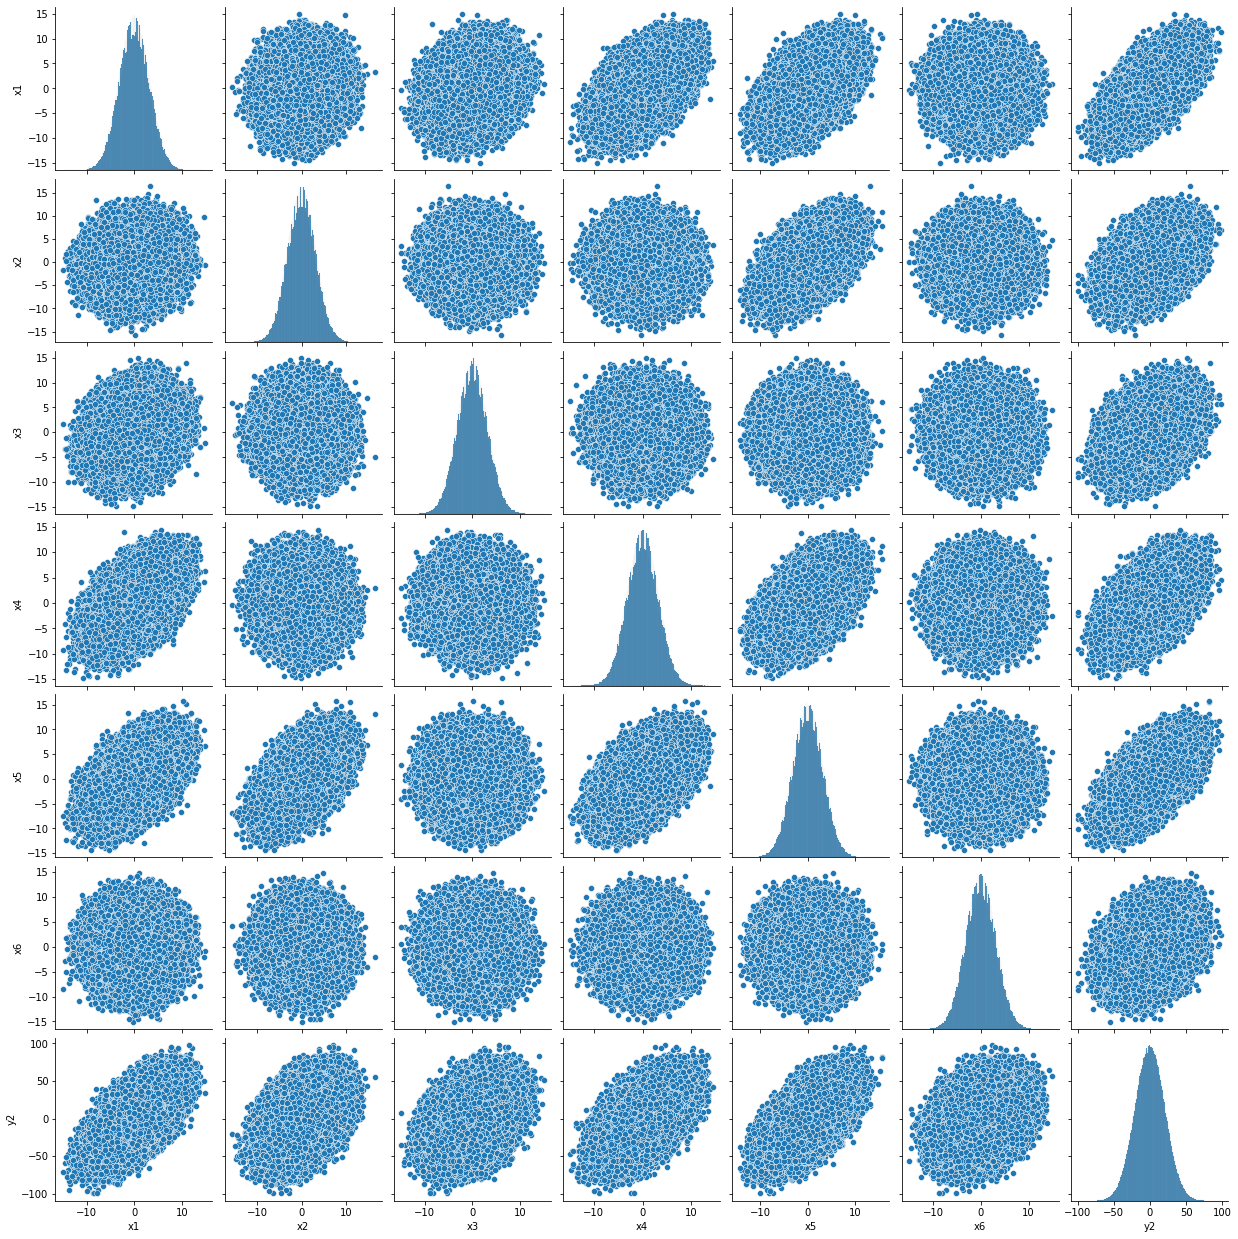

In [9]:
plt.figure(figsize=(12, 12))
sns.pairplot(pd.concat([X2, Y2], axis=1))
plt.show()

From the visualization of the pairvise scatterplot we can see that all the variables $x_{i}$ have a linear relationship with the y variable.

From the distribution plots, we can deduct that the variables are normal.

In [10]:
print(f'Mean of the Y variable: {Y2.mean()}')
print(f'Standart deviation of the Y variable: {Y2.std()}')

Mean of the Y variable: 0.0013578860745329946
Standart deviation of the Y variable: 20.81820302890223


## Deep learning model

In [11]:
# Input shape
inputRegression = Input(shape=(X2.shape[1], ))

# One neuron in the hidden layer with the linear activation function for regression
neuron = Dense(1, activation='linear', use_bias=False)(inputRegression)

# Defining the model
model = Model(inputRegression, neuron)

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


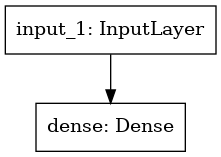

In [13]:
keras.utils.plot_model(model)

There are 6 parameters that will be trained in this model. Each correspond to the each of the features in the dataset.

In [14]:
# Defining a callback for early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0.001)

# Initiating the optimizer
optimizer = keras.optimizers.SGD(learning_rate=0.001)

# Compiling the model
model.compile(loss=losses.MeanSquaredError(), optimizer=optimizer)

# Fitting the model
history = model.fit(X2, Y2, epochs = 200, batch_size=2058, callbacks=[callback])

Epoch 1/200
486/486 [==============================] - 0s 394us/step - loss: 111.9074
Epoch 2/200
486/486 [==============================] - 0s 365us/step - loss: 99.9855
Epoch 3/200
486/486 [==============================] - 0s 370us/step - loss: 99.9825
Epoch 4/200
486/486 [==============================] - 0s 354us/step - loss: 99.9824
Epoch 5/200
486/486 [==============================] - 0s 361us/step - loss: 99.9826
Epoch 6/200
486/486 [==============================] - 0s 374us/step - loss: 99.9827
Epoch 7/200
486/486 [==============================] - 0s 431us/step - loss: 99.9815
Epoch 8/200
486/486 [==============================] - 0s 361us/step - loss: 99.9818
Epoch 9/200
486/486 [==============================] - 0s 400us/step - loss: 99.9821
Epoch 10/200
486/486 [==============================] - 0s 404us/step - loss: 99.9825: 0s - loss: 99.
Epoch 11/200
486/486 [==============================] - 0s 365us/step - loss: 99.9828
Epoch 12/200
486/486 [========================

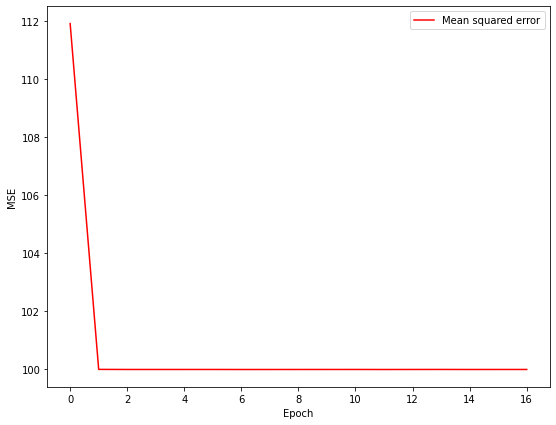

In [15]:
mse = history.history['loss']

epochs = range(len(mse))

plt.figure(figsize=(9, 7))
plt.plot(epochs, mse, 'r', label='Mean squared error')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [16]:
# Extracting the weights
beta = model.weights

In [17]:
# Coefficients near the regressors
beta[0].numpy().tolist()

[[1.9921004455566491],
 [2.003391424977394],
 [2.002394869305689],
 [1.9952026164988854],
 [0.9891427912364944],
 [1.995702444708852]]

According to the neural network the expected value $Y$ given $X$ is:
    
$$ E[Y | X] = 2 x_{1} + 2 x_{2} + 2 x_{3} + 2 x_{4} + x_{5} + 2 x_{6}$$

$$ 
\widehat{\beta} = \begin{bmatrix}  
2 \\
2 \\
2 \\
2 \\
1 \\
2
\end{bmatrix}
$$

## Logistic regression problem

The goal of fitting the neural network is to find the coefficients $\alpha$ and $\gamma$ in:

$$ p(Y | X, Z) = \dfrac{1}{1 - e^{-((\alpha X)c + \gamma Z})} $$

In [18]:
# Input shape
inputLogisticRegression1 = Input(shape=(X1.shape[1], ), name="X_input")
inputLogisticRegression2 = Input(shape=(Z1.shape[1], ), name="Z_input")

# One neuron in the hidden layer with the linear activation function
neuron = Dense(1, activation='linear', use_bias=False, name="X_linear")(inputLogisticRegression1)

# Additional information from z 
x = Concatenate(axis=1)([neuron, inputLogisticRegression2])

# Last logistic neuron 
logistic = Dense(1, activation='sigmoid', use_bias=False, name='Sigmoid')(x)

# Defining the model, 
model = Model([inputLogisticRegression1, inputLogisticRegression2], logistic)

In [19]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_input (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
X_linear (Dense)                (None, 1)            6           X_input[0][0]                    
__________________________________________________________________________________________________
Z_input (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           X_linear[0][0]                   
                                                                 Z_input[0][0]         

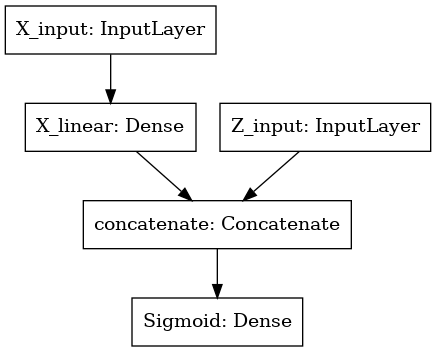

In [20]:
keras.utils.plot_model(model)

In [21]:
# Defining a callback for early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=100, min_delta=0.0001)

# Initiating the optimizer
optimizer = keras.optimizers.SGD()

# Compiling the model
model.compile(loss=losses.BinaryCrossentropy(), optimizer=optimizer)

# Fitting the model
history = model.fit([X1, Z1], Y1, epochs = 10000, callbacks=[callback], verbose=0)

In [22]:
loss = history.history['loss']

epochs = range(len(loss))

print(f"Evaluated in {len(loss)} epochs")

print(f"Initial loss value: {loss[0]}")
print(f"Final loss function value: {loss[-1]}")

Evaluated in 8552 epochs
Initial loss value: 2.0268685817718506
Final loss function value: 0.006139918230473995


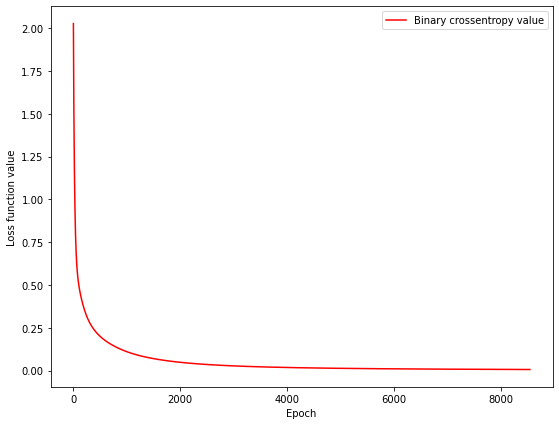

In [23]:
plt.figure(figsize=(9, 7))
plt.plot(epochs, loss, 'r', label='Binary crossentropy value')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss function value')
plt.show()

In [24]:
# Extracting the coefficients
w = model.weights

# Printing out the coefficients
print(w)

[<tf.Variable 'X_linear/kernel:0' shape=(6, 1) dtype=float64, numpy=
array([[-0.62214921],
       [-1.29044324],
       [-1.21987635],
       [-1.61879317],
       [ 0.8803721 ],
       [-0.34650065]])>, <tf.Variable 'Sigmoid/kernel:0' shape=(2, 1) dtype=float64, numpy=
array([[-2.55133162],
       [ 1.35942467]])>]


In [25]:
beta = w[0].numpy() * w[1].numpy()[0]

In [26]:
print(beta)

[[ 1.58730896]
 [ 3.29234864]
 [ 3.11230909]
 [ 4.13007819]
 [-2.24612118]
 [ 0.88403806]]


Thus in the equation (results may vary due to the initial random state of the weights): 

$$ p(Y | X, Z) = \dfrac{1}{1 - e^{-(\beta X + \gamma Z})} $$

$$ 
\widehat{\alpha} = \begin{bmatrix}  
1.59 \\
3.29 \\
3.11 \\
4.12 \\
-2.25 \\
0.88
\end{bmatrix}
$$

$$\widehat{\gamma} = 1.37$$